In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re


Dataset Used: UCSC-VLAA/MedReason  
https://huggingface.co/datasets/UCSC-VLAA/MedReason

In [ ]:
df = pd.read_json("hf://datasets/UCSC-VLAA/MedReason/ours_quality_33000.jsonl", lines=True)
df.head()

,dataset_name,id_in_dataset,question,answer,reasoning,options
0,medmcqa,7131,Urogenital Diaphragm is made up of the followi...,Colle's fascia. Explanation: Colle's fascia do...,Finding reasoning paths:\n1. Urogenital diaphr...,Answer Choices:\nA. Deep transverse Perineus\n...
1,medmcqa,7133,Child with Type I Diabetes. What is the advise...,After 5 years. Explanation: Screening for diab...,**Finding reasoning paths:**\n\n1. Type 1 Diab...,Answer Choices:\nA. After 5 years\nB. After 2 ...
2,medmcqa,7134,Most sensitive test for H pylori is-,Biopsy urease test. Explanation: <P>Davidson&;...,**Finding reasoning paths:**\n\n1. Consider th...,Answer Choices:\nA. Fecal antigen test\nB. Bio...
3,medmcqa,7137,Ligation of the common hepatic aery will compr...,Right gastric and right gastroepiploic aery. E...,**Finding reasoning paths:**\n\n1. Common hepa...,Answer Choices:\nA. Right and Left gastric aer...
4,medmcqa,7138,Typhoid investigation of choice in 1st week,Blood culture. Explanation: (A) Blood culture ...,Finding reasoning paths:\n\n1. Consider the pa...,Answer Choices:\nA. Blood culture\nB. Widal te...


# General Information

In [ ]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32682 entries, 0 to 32681
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   dataset_name   32682 non-null  object
 1   id_in_dataset  32682 non-null  int64 
 2   question       32682 non-null  object
 3   answer         32682 non-null  object
 4   reasoning      32682 non-null  object
 5   options        32682 non-null  object
dtypes: int64(1), object(5)
memory usage: 187.0 MB


In [ ]:
df.shape

(32682, 6)

In [ ]:
df.columns

Index(['dataset_name', 'id_in_dataset', 'question', 'answer', 'reasoning',
       'options'],
      dtype='object')

In [ ]:
df.dtypes

,0
dataset_name,object
id_in_dataset,int64
question,object
answer,object
reasoning,object
options,object


Null check

In [ ]:
print(df.isnull().sum())

dataset_name     0
id_in_dataset    0
question         0
answer           0
reasoning        0
options          0
dtype: int64


In [ ]:
print((df == '').sum())

dataset_name        0
id_in_dataset       0
question            0
answer              0
reasoning           0
options          7198
dtype: int64


# Exploratory Data Analysis

In [ ]:
# Finding number of unique dataset sources from dataset_name
df['dataset_name'].nunique()

9

In [ ]:
data_sources = df['dataset_name'].unique()
data_sources

array(['medmcqa', 'huatuo', 'medqa', 'pubmedqa_unlabeled', 'MMLU',
       'pubmedqa', 'LastHumanity', 'pubmedqa_artificial', 'MedXpertQA'],
      dtype=object)

In [ ]:
# Num questions from each source
df['dataset_name'].value_counts()

,count
dataset_name,
pubmedqa_artificial,8094
medqa,8016
huatuo,6475
medmcqa,6197
pubmedqa_unlabeled,1747
MMLU,827
MedXpertQA,666
pubmedqa,603
LastHumanity,57


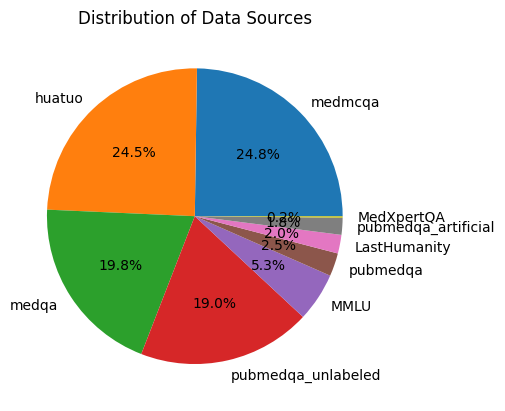

In [ ]:
# Pie chart of counts from each source
plt.pie(df['dataset_name'].value_counts(), labels=data_sources, autopct='%1.1f%%')
plt.title('Distribution of Data Sources')
plt.show()


In [ ]:
df['question_length'] = df['question'].apply(len)
df['answer_length'] = df['answer'].apply(len)

print(df[['question_length', 'answer_length']].describe())



       question_length  answer_length
count     32682.000000   32682.000000
mean        322.388777     319.890001
std         348.816164     387.175156
min           6.000000       1.000000
25%          92.000000      38.000000
50%         145.000000     232.000000
75%         489.000000     444.000000
max       13498.000000   12866.000000


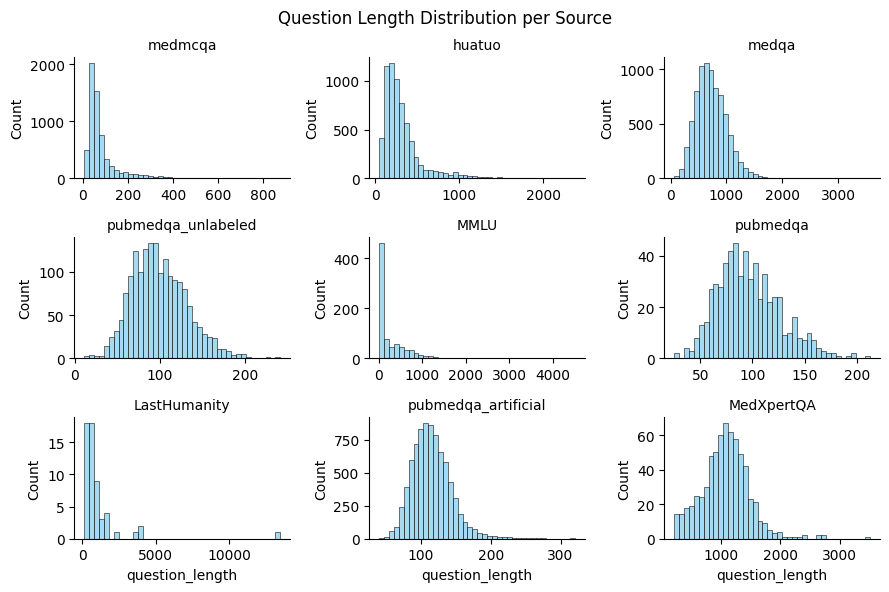

In [ ]:
g = sns.FacetGrid(df, col="dataset_name", col_wrap=3, height=3, sharex=False, sharey=False)
g.map(sns.histplot, "question_length", bins=40, color="skyblue")
g.set_titles(col_template="{col_name}")
g.fig.suptitle("Question Length Distribution per Source", fontsize=12)
g.fig.set_size_inches(9, 6)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

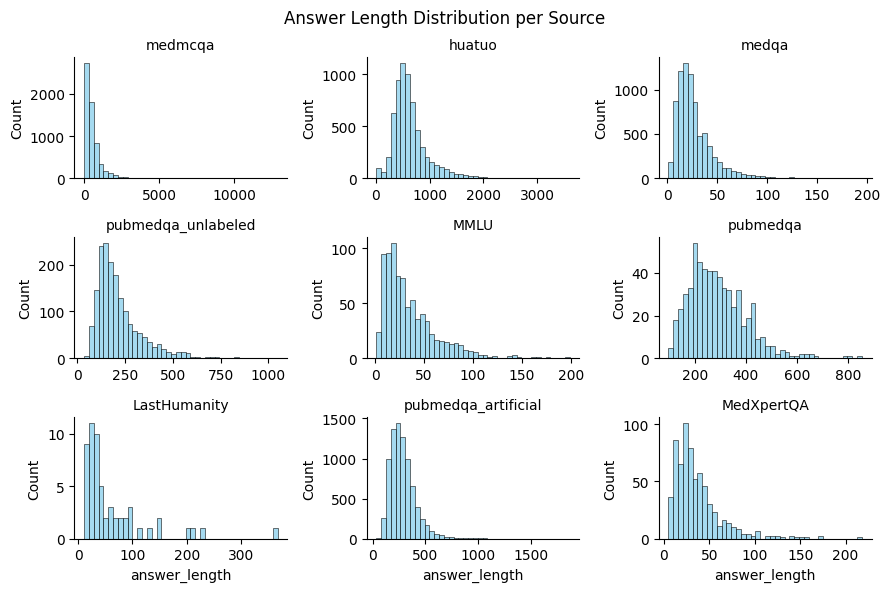

In [ ]:
g = sns.FacetGrid(df, col="dataset_name", col_wrap=3, height=3, sharex=False, sharey=False)
g.map(sns.histplot, "answer_length", bins=40, color="skyblue")
g.set_titles(col_template="{col_name}")
g.fig.suptitle("Answer Length Distribution per Source", fontsize=12)
g.fig.set_size_inches(9, 6)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [ ]:
# Answer length statistics per data source
df.groupby('dataset_name')['answer_length'].describe()

,count,mean,std,min,25%,50%,75%,max
dataset_name,,,,,,,,
LastHumanity,57.0,61.982456,65.143932,11.0,25.0,35.0,77.0,367.0
MMLU,827.0,35.037485,27.964303,1.0,15.0,27.0,48.0,199.0
MedXpertQA,666.0,36.084084,26.113612,5.0,19.0,29.0,45.0,218.0
huatuo,6475.0,629.681390,324.080626,5.0,428.0,562.0,739.0,3608.0
medmcqa,6197.0,524.119897,614.013682,1.0,163.0,374.0,676.0,12866.0
medqa,8016.0,27.217814,19.599679,1.0,14.0,22.0,34.0,195.0
pubmedqa,603.0,289.592040,112.497720,97.0,208.0,271.0,357.0,854.0
pubmedqa_artificial,8094.0,284.413146,123.931727,35.0,199.0,263.5,343.0,1871.0
pubmedqa_unlabeled,1747.0,216.430452,122.686164,35.0,134.0,182.0,259.5,1048.0


## Dataset Sources


### medmcqa

In [ ]:
# View sample from medmcqa
medmcqa_qs = df[df['dataset_name'] == 'medmcqa'].copy()
medmcqa_qs

,dataset_name,id_in_dataset,question,answer,reasoning,options,question_length,answer_length
0,medmcqa,7131,Urogenital Diaphragm is made up of the followi...,Colle's fascia. Explanation: Colle's fascia do...,Finding reasoning paths:\n1. Urogenital diaphr...,Answer Choices:\nA. Deep transverse Perineus\n...,57,343
1,medmcqa,7133,Child with Type I Diabetes. What is the advise...,After 5 years. Explanation: Screening for diab...,**Finding reasoning paths:**\n\n1. Type 1 Diab...,Answer Choices:\nA. After 5 years\nB. After 2 ...,104,592
2,medmcqa,7134,Most sensitive test for H pylori is-,Biopsy urease test. Explanation: <P>Davidson&;...,**Finding reasoning paths:**\n\n1. Consider th...,Answer Choices:\nA. Fecal antigen test\nB. Bio...,36,178
3,medmcqa,7137,Ligation of the common hepatic aery will compr...,Right gastric and right gastroepiploic aery. E...,**Finding reasoning paths:**\n\n1. Common hepa...,Answer Choices:\nA. Right and Left gastric aer...,65,403
4,medmcqa,7138,Typhoid investigation of choice in 1st week,Blood culture. Explanation: (A) Blood culture ...,Finding reasoning paths:\n\n1. Consider the pa...,Answer Choices:\nA. Blood culture\nB. Widal te...,43,1360
...,...,...,...,...,...,...,...,...
29157,medmcqa,7125,A 60-year-old nursing home resident presents w...,Contact precautions. Explanation: There are fo...,### Finding Reasoning Paths:\n1. **Clinical Pr...,Answer Choices:\nA. Standard precautions\nB. C...,340,1610
29158,medmcqa,7126,Transcripton is inhibited by:,Actinomycin D. Explanation: A i.e. Actinomycin,### Finding Reasoning Paths:\n1. mRNA transcri...,Answer Choices:\nA. Actinomycin D\nB. Amanitin...,29,46
29159,medmcqa,7128,Triage is –,Categorisation of the patients and treating th...,### Finding Reasoning Paths:\n1. **Severity of...,Answer Choices:\nA. Treating the most serious ...,11,715
29160,medmcqa,7129,All of the following are true in respect of he...,Autosomal recessive disorder. Explanation: Her...,### Finding Reasoning Paths:\n1. **Complement ...,Answer Choices:\nA. Deficiency of C1 inhibitor...,89,531


In [ ]:
for i in range(5):
    print(medmcqa_qs.iloc[i]['answer'])
    print()

Colle's fascia. Explanation: Colle's fascia does not contribute to the Urogenital Diaphragm. It is attached posteriorly to the posterior border of the urogenital diaphragm but does not form pa of this diaphragm. Ref: BDC, Volume 2, 4th Edition, Page 332; Grants Method of Anatomy, 11th Edition, Page 244; Gray's Anatomy, 36th Edition, Page 563

After 5 years. Explanation: Screening for diabetic retinopathy To prevent visual loss occurring from diabetic retinopathy a periodic follow-up is very impoant for a timely intervention. The recommendations for periodic fundus examination are as follows : First examination, 5 years after diagnosis of type 1 DM and at the time of diagnosis in type 2 DM. Every year, till there is no diabetic retinopathy or there is mild NPDR. Every 6 months, in moderate NPDR. Every 3 months, in severe NPDR Every 2 months, in PDR with no high-risk characteristics. Ref;A.K.Khurana; 6th edition; Page no: 280

Biopsy urease test. Explanation: <P>Davidson&;s principles an

In [ ]:
for i in range(5):
    print(medmcqa_qs.iloc[i]['options'])
    print()

Answer Choices:
A. Deep transverse Perineus
B. Perinial membrane
C. Colle's fascia
D. Sphincter Urethrae

Answer Choices:
A. After 5 years
B. After 2 years
C. After 10 years
D. At the time of diagnosis

Answer Choices:
A. Fecal antigen test
B. Biopsy urease test
C. Serological test
D. Urea breath test

Answer Choices:
A. Right and Left gastric aery
B. Right gastric and sho gastric aeries
C. Right gastroepiploic and sho gastric aeries
D. Right gastric and right gastroepiploic aery

Answer Choices:
A. Blood culture
B. Widal test
C. Stool culture
D. Urine culture



In [ ]:
def count_answer_choices(text):
    if pd.isnull(text):
        return 0
    lines = text.strip().split('\n')
    choice_lines = lines[1:]
    count = sum(bool(re.match(r'^[A-Z]\.', line.strip())) for line in choice_lines)
    return count

medmcqa_qs['num_choices'] = medmcqa_qs['options'].apply(count_answer_choices)

print(medmcqa_qs['num_choices'].value_counts())


num_choices
4    6197
Name: count, dtype: int64


### huatuo

In [ ]:
# View sample from huatuo
huatuo_qs = df[df['dataset_name'] == "huatuo"].copy()
huatuo_qs

,dataset_name,id_in_dataset,question,answer,reasoning,options
1306,huatuo,0,A 61-year-old woman with a long history of inv...,Cystometry in this case of stress urinary inco...,### Finding Reasoning Paths:\n1. Female stress...,
1307,huatuo,1,A 45-year-old man with a history of alcohol us...,Considering the clinical presentation of sudde...,### Finding Reasoning Paths:\n1. Chronic liver...,
1308,huatuo,2,A 45-year-old man presents with symptoms inclu...,Based on the clinical findings presented—wide-...,### Finding Reasoning Paths:\n1. Broad-based g...,
1309,huatuo,3,A patient with psoriasis was treated with syst...,The development of generalized pustules in a p...,### Finding Reasoning Paths:\n1. Psoriasis -> ...,
1310,huatuo,4,What is the most likely diagnosis for a 2-year...,Based on the described symptoms and the unusua...,### Finding Reasoning Paths:\n1. **Overweight ...,
...,...,...,...,...,...,...
23593,huatuo,6504,A large city has motor vehicles that produced ...,The total number of moles of carbon monoxide (...,### Finding Reasoning Paths:\n1. **Path 1**: U...,
23594,huatuo,6505,How should a 35-week pregnant female presentin...,A 35-week pregnant female presenting with seve...,### Finding Reasoning Paths:\n1. **Preeclampsi...,
23595,huatuo,6506,To which organelle are proteins directed when ...,Proteins synthesized by ribosomes attached to ...,### Finding Reasoning Paths:\n1. Ribosome → Ro...,
23596,huatuo,6508,A man with an upper abdominal injury shows sym...,Based on the symptoms described—right upper qu...,### Finding Reasoning Paths:\n1. **Right upper...,


In [ ]:
for i in range(5):
    print(huatuo_qs.iloc[i]['answer'])
    print()

Cystometry in this case of stress urinary incontinence would most likely reveal a normal post-void residual volume, as stress incontinence typically does not involve issues with bladder emptying. Additionally, since stress urinary incontinence is primarily related to physical exertion and not an overactive bladder, you would not expect to see any involuntary detrusor contractions during the test.

Considering the clinical presentation of sudden onset dysarthria, shuffling gait, and intention tremors in a 45-year-old man with a history of alcohol use who has been abstinent for the past 10 years, the most likely diagnosis is acquired hepatocerebral degeneration.

This condition is associated with chronic liver disease, which can often be a consequence of long-term alcohol use. Despite the patient's abstinence from alcohol for a decade, previous alcohol use may have led to underlying liver dysfunction. This dysfunction, even if subclinical, can cause encephalopathy due to the accumulation

In [ ]:
huatuo_qs['options'].value_counts()

,count
options,
,6475


### pubmedqa_unlabeled

In [ ]:
pubmedqa_unlabeled_qs = df[df['dataset_name'] == "pubmedqa_unlabeled"].copy()
pubmedqa_unlabeled_qs

,dataset_name,id_in_dataset,question,answer,reasoning,options,question_length,answer_length
12537,pubmedqa_unlabeled,11515,Can finasteride reverse the progress of benign...,The efficacy of therapy with finasteride 5 mg ...,**Finding reasoning paths:**\n\n1. Benign pros...,Answer Choices:\nA. Yes\nB. No,69,388
12538,pubmedqa_unlabeled,11522,Severe hyponatremia associated with anorexia n...,Hyponatremia sometimes seen in anorexia nervos...,**Finding reasoning paths:**\n\n1. Anorexia ne...,Answer Choices:\nA. Yes\nB. No,107,120
12539,pubmedqa_unlabeled,11529,Can nebulized naloxone be used safely and effe...,Nebulized naloxone is a safe and effective nee...,**Finding reasoning paths:**\n\n1. Acute opioi...,Answer Choices:\nA. Yes\nB. No,114,163
12540,pubmedqa_unlabeled,11543,Can we avoid percutaneous nephrolithotomy in h...,Conservative management of asymptomatic large ...,Finding reasoning paths:\n\n1. Nephrolithiasis...,Answer Choices:\nA. Yes\nB. No,109,151
12541,pubmedqa_unlabeled,11551,Dynamic MDCT of the pancreas: is time-density ...,The morphology of MDCT perfusion time-density ...,**Finding reasoning paths:**\n\n1. **Understan...,Answer Choices:\nA. Yes\nB. No,118,190
...,...,...,...,...,...,...,...,...
30113,pubmedqa_unlabeled,7380,Does stigma keep poor young immigrant and U.S....,Stigma-related concerns are most common among ...,### Finding Reasoning Paths:\n1. **Cultural an...,Answer Choices:\nA. Yes\nB. No,107,188
30114,pubmedqa_unlabeled,7389,Selective mutism and social anxiety disorder: ...,These results support earlier uncontrolled fin...,### Finding Reasoning Paths:\n1. **Familial re...,Answer Choices:\nA. Yes\nB. No,64,120
30115,pubmedqa_unlabeled,7402,Is levofloxacin necessary to prevent postopera...,Levofloxacin is not necessary to prevent posto...,### Finding Reasoning Paths:\n1. **Wound heali...,Answer Choices:\nA. Yes\nB. No,99,122
30116,pubmedqa_unlabeled,7406,Does the energy expenditure status in obstruct...,In apneic men energy expenditure relative to b...,### Finding Reasoning Paths:\n1. Obstructive s...,Answer Choices:\nA. Yes\nB. No,95,160


In [ ]:
for i in range(5):
    print(pubmedqa_unlabeled_qs.iloc[i]['answer'])
    print()

The efficacy of therapy with finasteride 5 mg in improving both symptoms and maximum urinary flow rate and reducing prostate volume has been shown to be maintained during 24 months while patients receiving placebo experienced a return to baseline or deterioration of these parameters during the study. These results demonstrate that finasteride can reverse the natural progression of BPH.

Hyponatremia sometimes seen in anorexia nervosa must lead to the search of inappropriate antidiuretic hormone secretion.

Nebulized naloxone is a safe and effective needleless alternative for prehospital treatment of suspected opioid overdose in patients with spontaneous respirations.

Conservative management of asymptomatic large kidney stones appears to be a safe alternative to PCNL in elderly patients with significant comorbidites.

The morphology of MDCT perfusion time-density curves appears to be useful in characterizing pancreatic lesions, and might help overcome the differences in scan and postpr